<img width="800px" src="../fidle/img/header.svg"></img>

# <!-- TITLE --> [PMNIST1] - Simple classification with DNN
<!-- DESC -->Example of classification with a fully connected neural network, using Pytorch
<!-- AUTHOR : Laurent Risser (CNRS/IMT) -->

## Objectives :
 - Recognizing handwritten numbers
 - Understanding the principle of a classifier DNN network 
 - Implementation with PyTorch 


The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology) is a must for Deep Learning.  
It consists of 60,000 small images of handwritten numbers for learning and 10,000 for testing.


## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Create a model
 - Train the model
 - Evaluate the result


## Step 1 - Init python stuff

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision  #to get the MNIST dataset


import numpy as np
import matplotlib.pyplot as plt
import sys,os

import fidle
from modules.fidle_pwk_additional import convergence_history_CrossEntropyLoss

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('PMNIST1')

<br>**FIDLE - Environment initialization**

Version              : 2.3.2
Run id               : PMNIST1
Run dir              : ./run/PMNIST1
Datasets dir         : /data/datasets-fidle
Start time           : 22/09/25 17:19:45
Hostname             : 523f51ec6e3b (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Update torch cache   : False
Save figs            : ./run/PMNIST1/figs (False)
numpy                : 2.2.1
sklearn              : 1.6.0
yaml                 : 6.0.2
matplotlib           : 3.10.0
pandas               : 2.2.3
torch                : 2.5.1+cpu
torchvision          : 0.20.1+cpu


## Step 2 - Retrieve data
MNIST is one of the most famous historic dataset.  
Include in [torchvision datasets](https://pytorch.org/vision/stable/datasets.html)

In [2]:
#get and format the training set
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
x_train=mnist_trainset.data.type(torch.DoubleTensor)
y_train=mnist_trainset.targets


#get and format the test set
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
x_test=mnist_testset.data.type(torch.DoubleTensor)
y_test=mnist_testset.targets

#check data shape and format
print("Size of the train and test observations")
print(" -> x_train : ",x_train.shape)
print(" -> y_train : ",y_train.shape)
print(" -> x_test  : ",x_test.shape)
print(" -> y_test  : ",y_test.shape)

print("\nRemark that we work with torch tensors and not numpy arrays:")
print(" -> x_train.dtype = ",x_train.dtype)
print(" -> y_train.dtype = ",y_train.dtype)


Size of the train and test observations
 -> x_train :  torch.Size([60000, 28, 28])
 -> y_train :  torch.Size([60000])
 -> x_test  :  torch.Size([10000, 28, 28])
 -> y_test  :  torch.Size([10000])

Remark that we work with torch tensors and not numpy arrays:
 -> x_train.dtype =  torch.float64
 -> y_train.dtype =  torch.int64


## Step 3 - Preparing the data

In [3]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

xmax=x_train.max()
x_train = x_train / xmax
x_test  = x_test  / xmax

print('After normalization  : Min={}, max={}'.format(x_train.min(),x_train.max()))


Before normalization : Min=0.0, max=255.0
After normalization  : Min=0.0, max=1.0


### Have a look

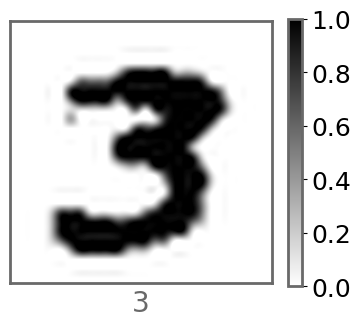

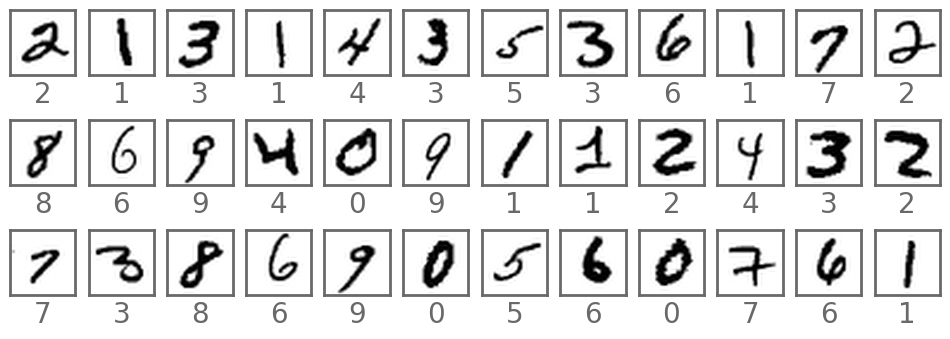

In [4]:
np_x_train=x_train.numpy().astype(np.float64)
np_y_train=y_train.numpy().astype(np.uint8)

fidle.scrawler.images(np_x_train,np_y_train , [27],  x_size=5,y_size=5, colorbar=True)
fidle.scrawler.images(np_x_train,np_y_train, range(5,41), columns=12)


## Step 4 - Create model
About informations about : 
 - [Optimizer](https://pytorch.org/docs/stable/optim.html)
 - [Basic neural-network blocks](https://pytorch.org/docs/stable/nn.html)
 - [Loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [14]:
class MyModel(nn.Module):
    """
    Basic fully connected neural-network
    """
    def __init__(self):
        hidden1     = 100
        hidden2     = 100
        super(MyModel, self).__init__()
        self.hidden1 = nn.Linear(784, hidden1)
        self.hidden2 = nn.Linear(hidden1, hidden2)
        self.hidden3 = nn.Linear(hidden2, 10)

    def forward(self, x):
        x = x.view(-1,784)   #flatten the images before using fully-connected layers
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.hidden3(x)
        x = F.softmax(x, dim=0)
        return x

    
    
model = MyModel()
    


## Step 5 - Train the model

### 5.1 - Stochastic gradient descent strategy to fit the model


In [15]:
def fit(model,X_train,Y_train,X_test,Y_test, EPOCHS = 5, BATCH_SIZE = 32):
    
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) #lr is the learning rate
    model.train()
    
    history=convergence_history_CrossEntropyLoss()
    
    history.update(model,X_train,Y_train,X_test,Y_test)
    
    n=X_train.shape[0] #number of observations in the training data
    
    #stochastic gradient descent
    for epoch in range(EPOCHS):
        
        batch_start=0
        epoch_shuffler=np.arange(n) 
        np.random.shuffle(epoch_shuffler) #remark that 'utilsData.DataLoader' could be used instead
        
        while batch_start+BATCH_SIZE < n:
            #get mini-batch observation
            mini_batch_observations = epoch_shuffler[batch_start:batch_start+BATCH_SIZE]
            var_X_batch = Variable(X_train[mini_batch_observations,:,:]).float() #the input image is flattened
            var_Y_batch = Variable(Y_train[mini_batch_observations])
            
            #gradient descent step
            optimizer.zero_grad()               #set the parameters gradients to 0
            Y_pred_batch = model(var_X_batch)   #predict y with the current NN parameters
            
            curr_loss = loss(Y_pred_batch, var_Y_batch)  #compute the current loss
            curr_loss.backward()                         #compute the loss gradient w.r.t. all NN parameters
            optimizer.step()                             #update the NN parameters
            
            #prepare the next mini-batch of the epoch
            batch_start+=BATCH_SIZE
            
        history.update(model,X_train,Y_train,X_test,Y_test)
    
    return history



### 5.2 - Fit the model

In [7]:

batch_size  = 512
epochs      = 128


history=fit(model,x_train,y_train,x_test,y_test,EPOCHS=epochs,BATCH_SIZE = batch_size)



## Step 6 - Evaluate
### 6.1 - Final loss and accuracy

In [8]:
var_x_test = Variable(x_test[:,:,:]).float()
var_y_test = Variable(y_test[:])
y_pred = model(var_x_test)

loss = nn.CrossEntropyLoss()
curr_loss = loss(y_pred, var_y_test)

val_loss = curr_loss.item()
val_accuracy  = float( (torch.argmax(y_pred, dim= 1) == var_y_test).float().mean() )


print('Test loss     :', val_loss)
print('Test accuracy :', val_accuracy)


Test loss     : 2.3016884326934814
Test accuracy : 0.9480999708175659


### 6.2 - Plot history

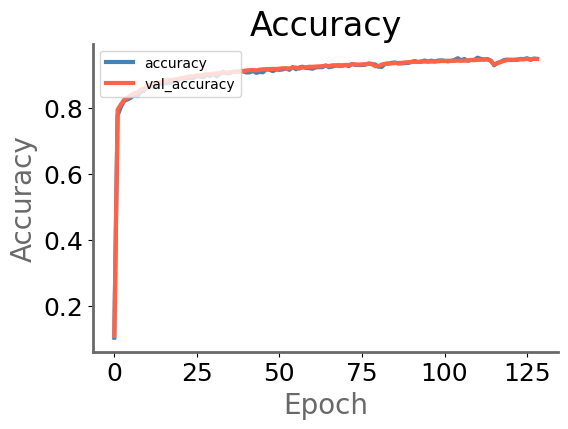

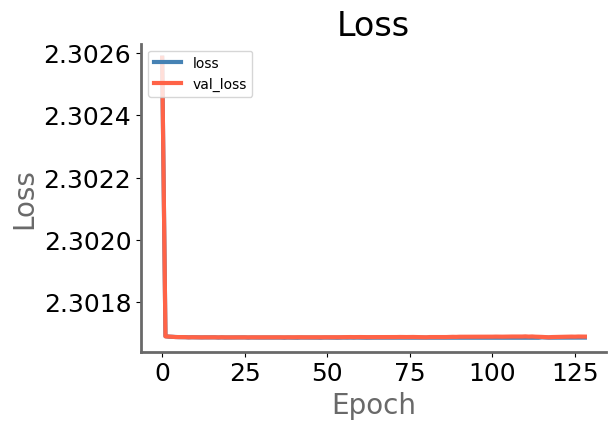

In [9]:
fidle.scrawler.history(history, figsize=(6,4))


### 6.3 - Plot results

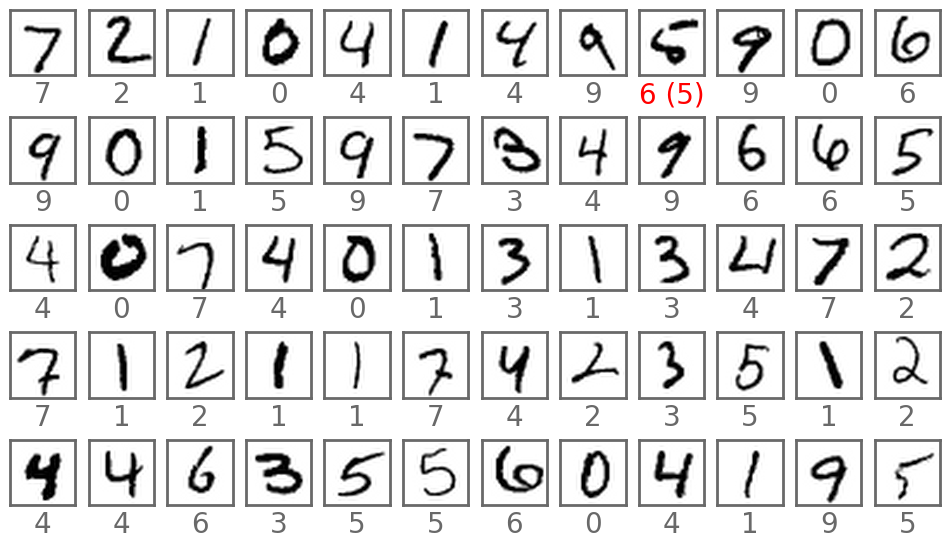

In [10]:
y_pred = model(var_x_test)
np_y_pred_label = torch.argmax(y_pred, dim= 1).numpy().astype(np.uint8)

np_x_test=x_test.numpy().astype(np.float64)
np_y_test=y_test.numpy().astype(np.uint8)

fidle.scrawler.images(np_x_test, np_y_test, range(0,60), columns=12, x_size=1, y_size=1, y_pred=np_y_pred_label)


### 6.4 - Plot some errors

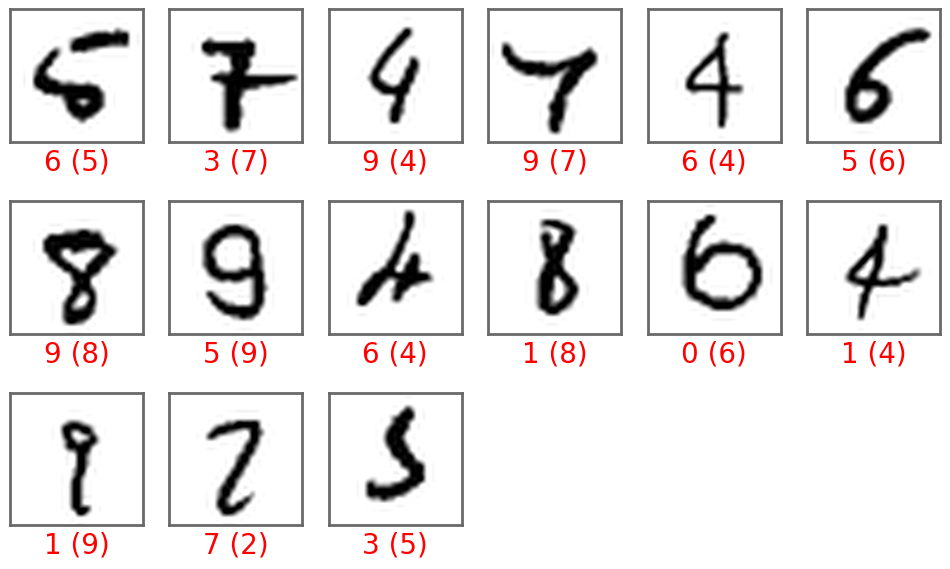

In [11]:
errors=[ i for i in range(len(np_y_test)) if np_y_pred_label[i]!=np_y_test[i] ]
errors=errors[:min(24,len(errors))]
fidle.scrawler.images(np_x_test, np_y_test, errors[:15], columns=6, x_size=2, y_size=2, y_pred=np_y_pred_label)


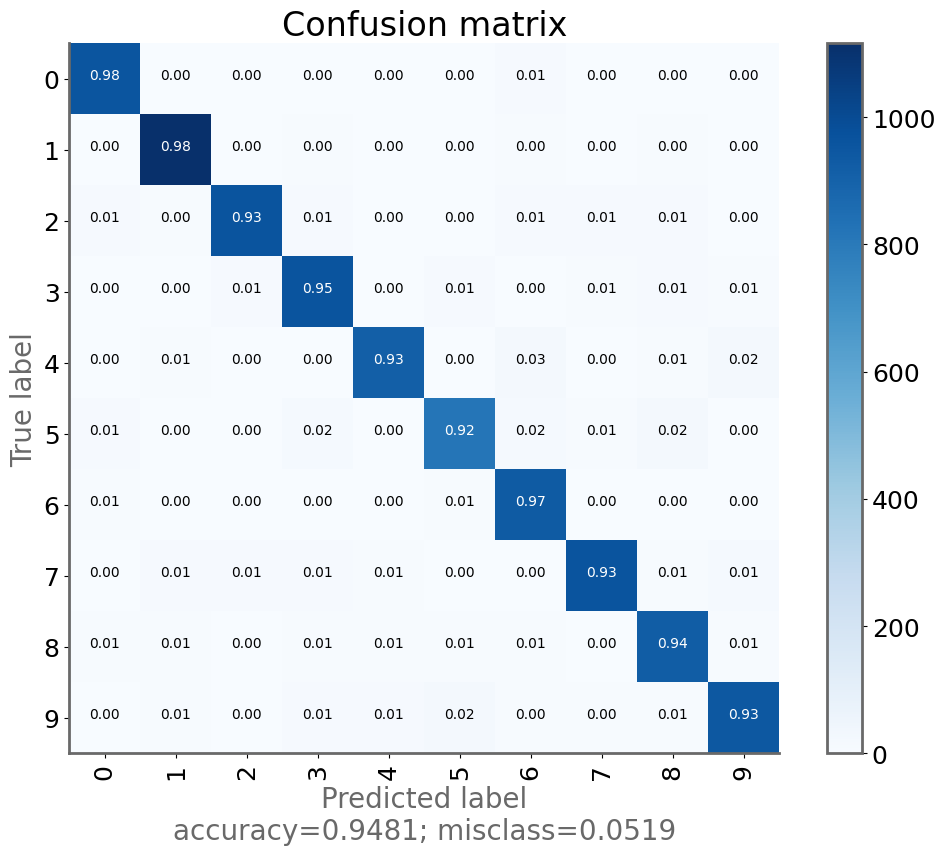

In [12]:
fidle.scrawler.confusion_matrix(np_y_test,np_y_pred_label, range(10))


<div class="todo">
    A few things you can do for fun:
    <ul>
        <li>Changing the network architecture (layers, number of neurons, etc.)</li>
        <li>Display a summary of the network</li>
        <li>Retrieve and display the softmax output of the network, to evaluate its "doubts".</li>
    </ul>
</div>

---
<img width="80px" src="../fidle/img/logo-paysage.svg"></img>